In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
rc = {'font.sans-serif': 'SimHei', 'axes.unicode_minus': False}
sns.set(context="talk", style="ticks", rc=rc)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
file_path = '附件1 近5年402家供应商的相关数据.xlsx'

order_df = pd.read_excel(file_path, sheet_name='企业的订货量（m³）')
supply_df = pd.read_excel(file_path, sheet_name='供应商的供货量（m³）')

order_df.head()

,供应商ID,材料分类,W001,W002,W003,W004,W005,W006,W007,W008,...,W231,W232,W233,W234,W235,W236,W237,W238,W239,W240
0,S001,B,0,0,0,43,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,S002,A,1,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,0,1
2,S003,C,7,1,0,0,0,1,4,50,...,10,3,50,20,20,7,10,9,20,10
3,S004,B,0,1,1,100,0,85,0,0,...,1,0,1,0,0,0,0,1,0,0
4,S005,A,30,60,60,60,70,70,60,70,...,80,70,70,70,70,70,70,70,70,80


## S007的订货量、供应量、供货准确度图

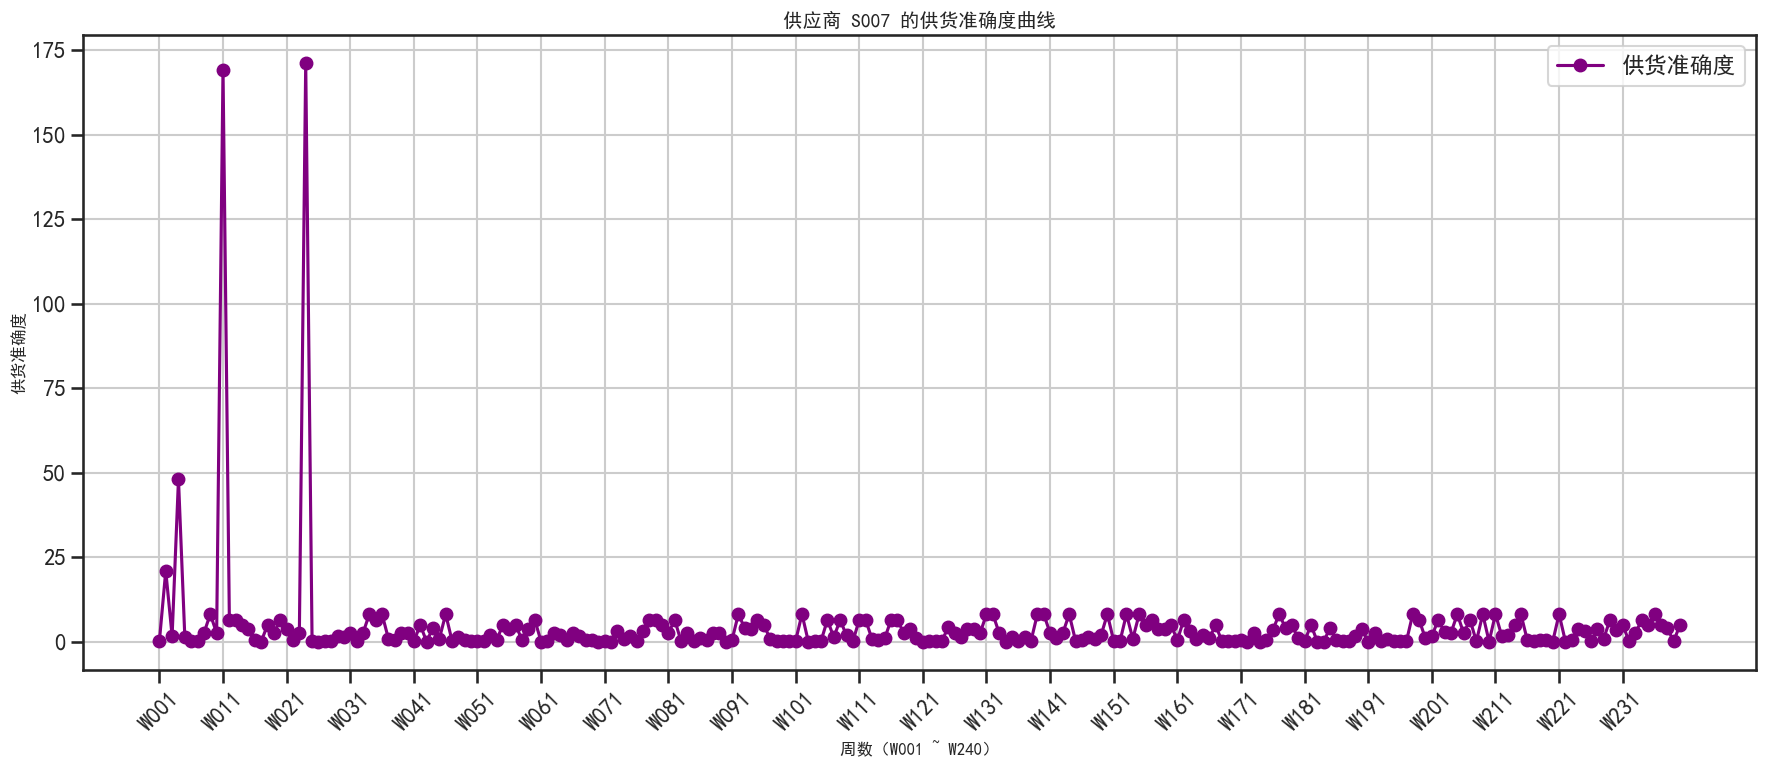

In [41]:
s007_order = order_df[order_df['供应商ID'] == 'S007'].iloc[0]
s007_supply = supply_df[supply_df['供应商ID'] == 'S007'].iloc[0]

weeks = s007_order.index[2:]
order_values = s007_order.values[2:].astype(float)
supply_values = s007_supply.values[2:].astype(float)

accuracy = (supply_values - order_values) ** 2 / order_values
accuracy[order_values == 0] = np.nan

data = pd.DataFrame({
    'Week': weeks,
    'Order': order_values,
    'Supply': supply_values,
    'Accuracy': accuracy
})

plt.figure(figsize=(18, 8))
plt.plot(data['Week'], data['Accuracy'], marker='o', linestyle='-', color='purple', label='供货准确度')
plt.title('供应商 S007 的供货准确度曲线', fontsize=14)
plt.xlabel('周数（W001 ~ W240）', fontsize=12)
plt.ylabel('供货准确度', fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(ticks=range(0, len(weeks), 10), labels=weeks[::10], rotation=45)
plt.tight_layout()
plt.show()

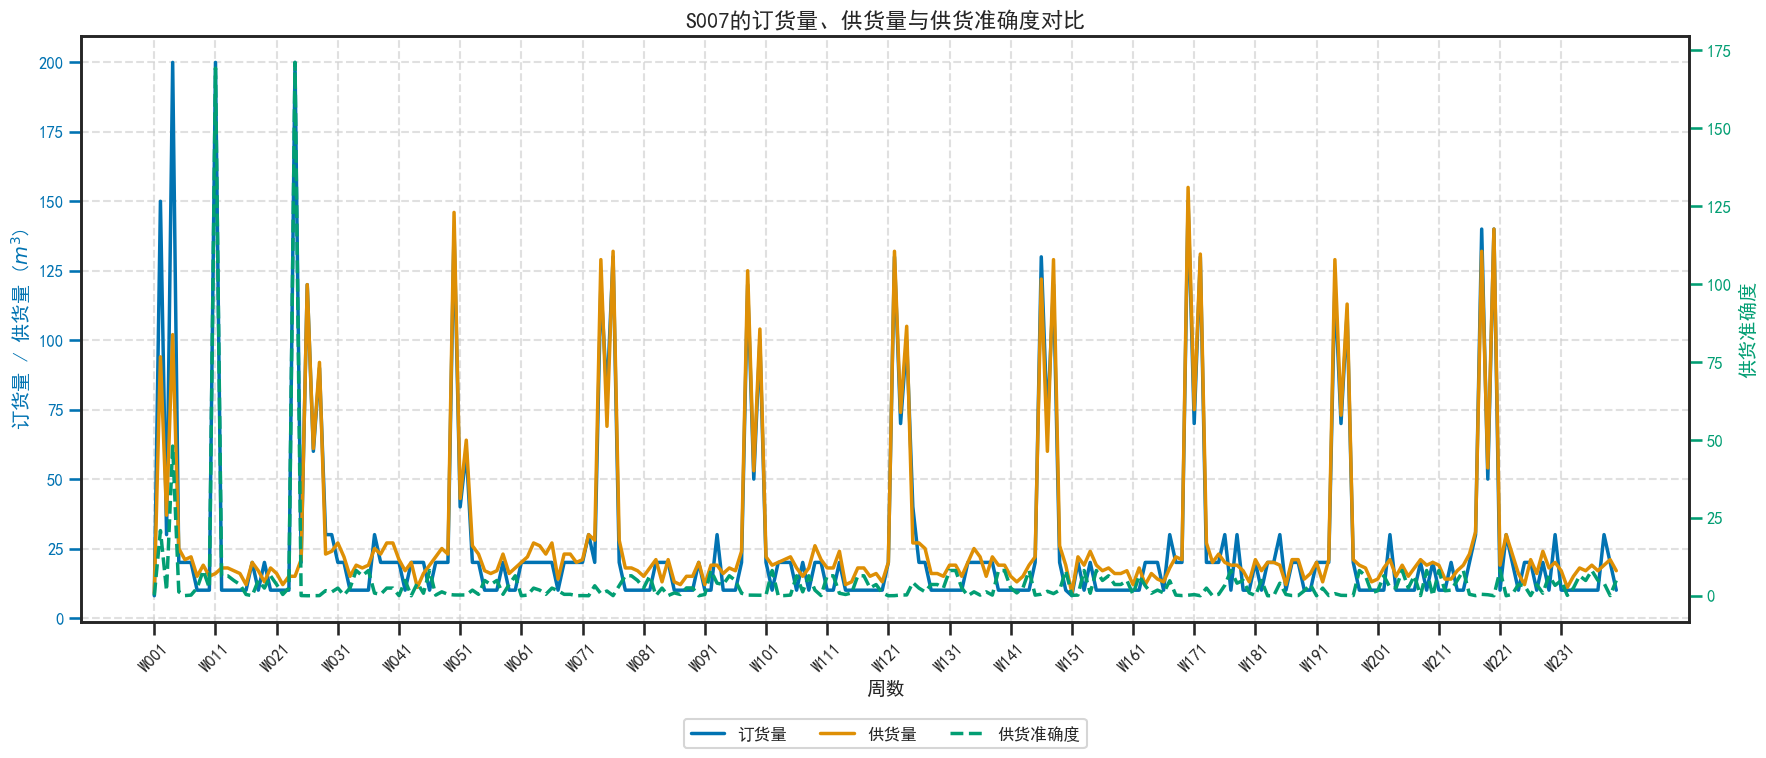

In [33]:
colors = sns.color_palette("colorblind", 3)
fig, ax1 = plt.subplots(figsize=(18, 8))
ax1.plot(data['Week'], data['Order'], color=colors[0], linewidth=2.5, label='订货量')
ax1.plot(data['Week'], data['Supply'], color=colors[1], linewidth=2.5, label='供货量')
ax1.set_xlabel('周数', fontsize=14)
ax1.set_ylabel('订货量 / 供货量 ($m^3$)', fontsize=14, color=colors[0])
for tick in ax1.get_xticklabels():
    tick.set_fontsize(12)
for tick in ax1.get_yticklabels():
    tick.set_fontsize(12)
ax1.tick_params(axis='y', colors=colors[0])
ax1.grid(True, linestyle='--', alpha=0.6)
ax2 = ax1.twinx()
ax2.plot(data['Week'], data['Accuracy'], color=colors[2], linestyle='--', linewidth=2.5, label='供货准确度')
ax2.set_ylabel('供货准确度', fontsize=14, color=colors[2])
ax2.tick_params(axis='y', colors=colors[2])
for tick in ax2.get_yticklabels():
    tick.set_fontsize(12)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3,
           fontsize=12, frameon=True, shadow=False)
plt.title('S007的订货量、供货量与供货准确度对比', fontsize=16)
ax1.set_xticks(range(0, len(weeks), 10))
ax1.set_xticklabels(weeks[::10], rotation=45, fontsize=12)
fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

## S229 在每周A类原材料供货总量的占比

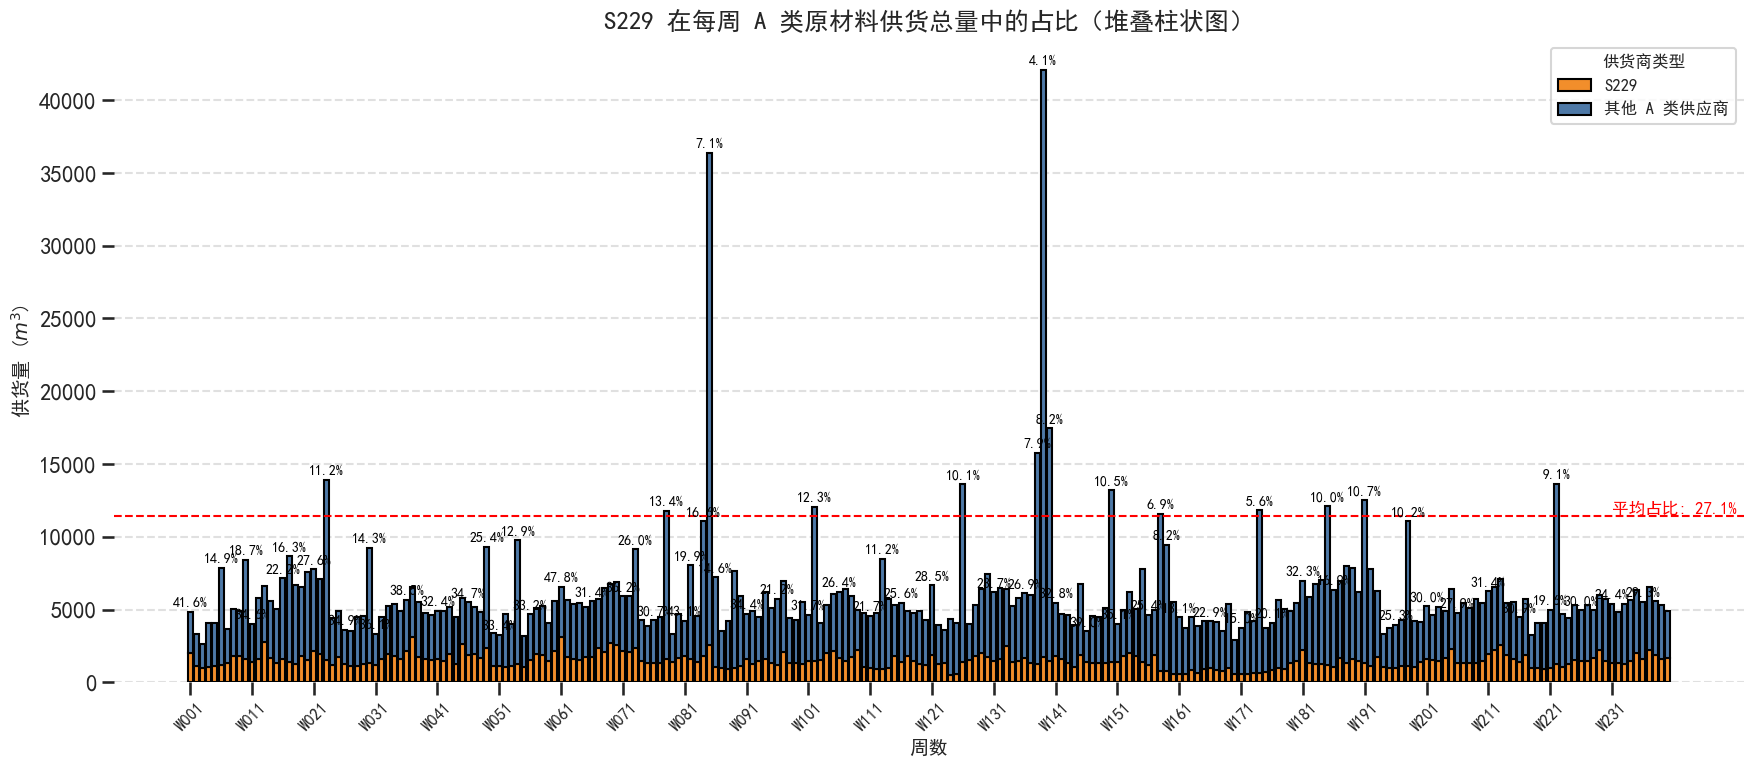

In [82]:
a_suppliers = supply_df[supply_df['材料分类'] == 'A']
s229_row = a_suppliers[a_suppliers['供应商ID'] == 'S229']
s229_supply = s229_row.iloc[:, 2:].values[0].astype(float)
other_a_suppliers = a_suppliers[a_suppliers['供应商ID'] != 'S229']
total_other_supply = other_a_suppliers.iloc[:, 2:].sum().values.astype(float)
total_a_supply = total_other_supply + s229_supply

# S229的占比
s229_ratio = np.zeros_like(s229_supply)
non_zero_mask = total_a_supply > 0
s229_ratio[non_zero_mask] = s229_supply[non_zero_mask] / total_a_supply[non_zero_mask]
weeks = [f'W{i:03d}' for i in range(1, len(s229_supply) + 1)]
df_plot = pd.DataFrame({
    'Other': total_other_supply,
    'S229': s229_supply
}, index=weeks)
avg_ratio = np.nanmean(s229_ratio)
max_value = max(df_plot.sum(axis=1))


sns.set(context="talk", style="ticks", rc={'font.sans-serif': 'SimHei', 'axes.unicode_minus': False})
fig, ax = plt.subplots(figsize=(18, 8))
bars_s229 = ax.bar(df_plot.index, df_plot['S229'], label='S229', color='#F28E2B', edgecolor='black')
bars_other = ax.bar(df_plot.index, df_plot['Other'], bottom=df_plot['S229'], label='其他 A 类供应商', color='#4E79A7', edgecolor='black')
for i, (index, row) in enumerate(df_plot.iterrows()):
    total = row['Other'] + row['S229']
    if total > 0:
        ratio = row['S229'] / total
        if total > 8000:
            ax.text(i, row['S229'] + row['Other']+600, f'{ratio:.1%}', ha='center', va='center', fontsize=10, color='black', fontweight='bold')
        else:
            if i % 5 == 0:
                ax.text(i, row['S229'] + row['Other']+600, f'{ratio:.1%}', ha='center', va='center', fontsize=10, color='black', fontweight='bold')
avg_ratio = np.nanmean(s229_ratio)
max_value = max(df_plot.sum(axis=1))
ax.set_title('S229 在每周 A 类原材料供货总量中的占比（堆叠柱状图）', fontsize=18)
ax.set_xlabel('周数', fontsize=14)
ax.set_ylabel('供货量 ($m^3$)', fontsize=14)
xticks_indices = range(0, len(weeks), 10)
xticks_labels = weeks[::10]
ax.set_xticks(xticks_indices)
ax.set_xticklabels(xticks_labels, rotation=45, fontsize=12)
ax.legend(['S229', '其他 A 类供应商'], fontsize=12, title='供货商类型', title_fontsize=12)
ax.axhline(avg_ratio * max_value, color='red', linestyle='--', linewidth=1.5)
ax.text(len(df_plot) - 10, avg_ratio * max_value, f'平均占比: {avg_ratio:.1%}', color='red', fontsize=12, va='bottom')
sns.despine(left=True, bottom=True)
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## S361的供货量-订货量方差

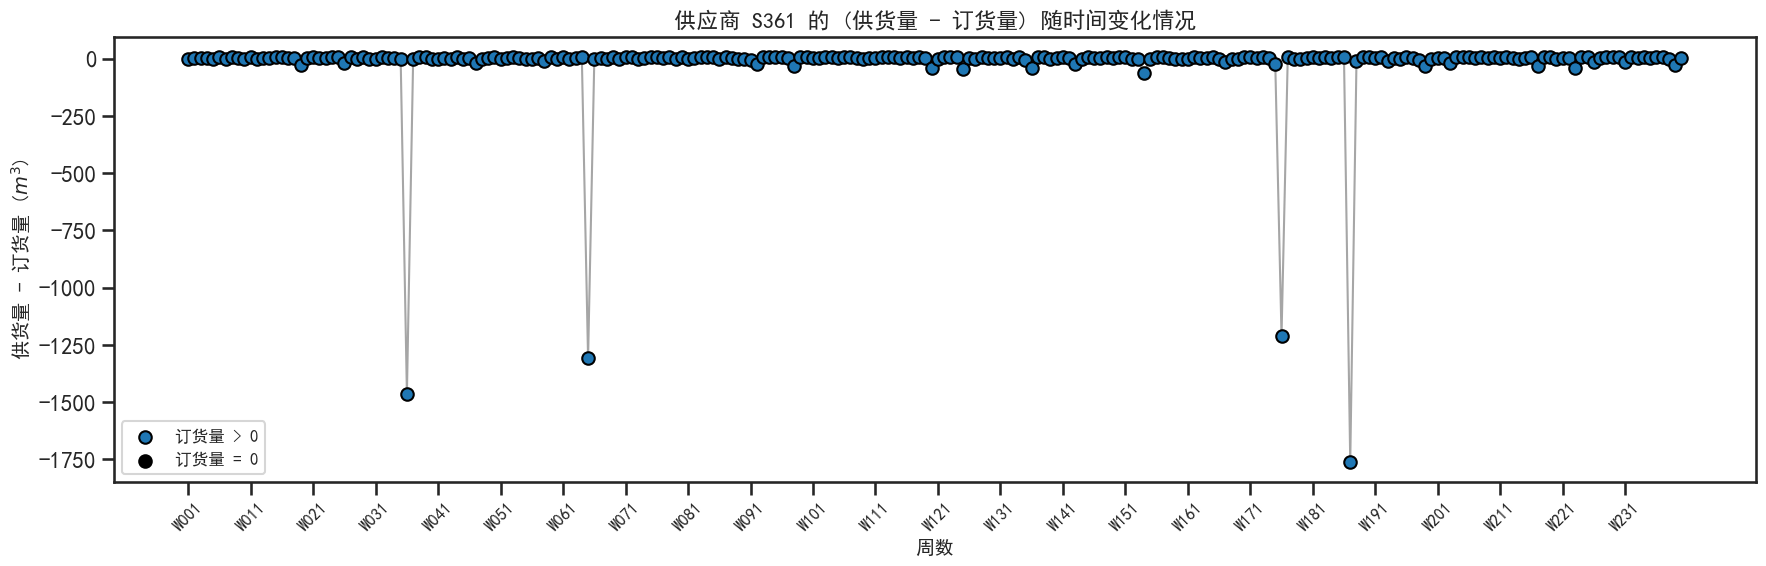

In [34]:
sns.set(context="talk", style="ticks", rc={'font.sans-serif': 'SimHei', 'axes.unicode_minus': False})
s361_order = order_df[order_df['供应商ID'] == 'S361'].iloc[0]
s361_supply = supply_df[supply_df['供应商ID'] == 'S361'].iloc[0]
weeks = s361_order.index[2:].tolist()
order_values = s361_order.values[2:].astype(float)
supply_values = s361_supply.values[2:].astype(float)
deviation = supply_values - order_values

data = pd.DataFrame({
    'Week': weeks,
    'Order': order_values,
    'Supply': supply_values,
    'Deviation': deviation
})

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(data['Week'], data['Deviation'], color='gray', alpha=0.7, linewidth=1.5, zorder=1)
non_zero_mask = data['Order'] != 0
zero_mask = data['Order'] == 0
ax.scatter(data[non_zero_mask]['Week'], data[non_zero_mask]['Deviation'],
          color='#1f77b4', label='订货量 > 0', edgecolor='black', zorder=2)
ax.scatter(data[zero_mask]['Week'], data[zero_mask]['Deviation'],
          color='black', label='订货量 = 0', edgecolor='black', zorder=2)
ax.set_title('供应商 S361 的 (供货量 - 订货量) 随时间变化情况', fontsize=16)
ax.set_xlabel('周数', fontsize=14)
ax.set_ylabel('供货量 - 订货量 ($m^3$)', fontsize=14)
xticks_indices = range(0, len(weeks), 10)
xticks_labels = weeks[::10]
ax.set_xticks(xticks_indices)
ax.set_xticklabels(xticks_labels, rotation=45, fontsize=12)
ax.grid(False)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 评价

In [47]:
supplier_ids = supply_df.iloc[:, 0]
categories = supply_df.iloc[:, 1]
order_data = order_df.iloc[:, 2:242]
supply_data = supply_df.iloc[:, 2:242]

orders = order_data.values
supplies = supply_data.values

# 初始化结果数组
n_suppliers = len(supplier_ids)
results = {
    '供应商编号': supplier_ids.tolist(),
    '类别': categories.tolist(),
    '供货准确度': [],
    '大额订单总量': [],
    '供货次数': [],
    '违约次数': [],
    '同类材料占有率': [],
    '供货稳定性': []
}

In [48]:
for i in range(n_suppliers):
    order = orders[i, :]
    supply = supplies[i, :]
    # 1. 供货准确度
    mask = order != 0
    diff_squared = (supply[mask] - order[mask]) ** 2
    accuracy = np.mean(diff_squared / order[mask]) if np.any(mask) else 0
    results['供货准确度'].append(accuracy)

    # 2. 大额订单总量 > 300
    large_order_mask = order >= 300
    large_total = np.sum(supply[large_order_mask])
    results['大额订单总量'].append(large_total)

    # 3. 供货次数
    supply_count = np.sum(supply > 0)
    results['供货次数'].append(supply_count)

    # 4. 违约次数
    breach_count = np.sum((supply < order) & (order > 0))
    results['违约次数'].append(breach_count)

In [50]:
# 5. 同类材料占有率
category_weekly_supply = {}

for i in range(n_suppliers):
    category = categories[i]
    if category not in category_weekly_supply:
        category_weekly_supply[category] = np.zeros(240)
    category_weekly_supply[category] += supplies[i, :]

market_shares = []

for i in range(n_suppliers):
    category = categories[i]
    total_supply = category_weekly_supply[category]
    supply = supplies[i, :]

    with np.errstate(divide='ignore', invalid='ignore'):
        share = np.where(total_supply != 0, supply / total_supply, 0)
    avg_share = np.mean(share)
    market_shares.append(avg_share)

results['同类材料占有率'] = market_shares

# 6. 供货稳定性
stabilities = []

for i in range(n_suppliers):
    diff = supplies[i, :] - orders[i, :]
    stability = np.var(diff)
    stabilities.append(stability)
results['供货稳定性'] = stabilities

In [51]:
metrics_df = pd.DataFrame(results)
metrics_df.head()

,供应商编号,类别,供货准确度,大额订单总量,供货次数,违约次数,同类材料占有率,供货稳定性
0,S001,B,2.156044,0,25,72,0.000052,20.791597
1,S002,A,1.305714,0,71,31,0.000193,16.344167
2,S003,C,7.731672,1087,191,29,0.008869,2239.918733
3,S004,B,6.377180,0,33,82,0.000069,229.833316
4,S005,A,0.658764,0,107,11,0.005344,11.671597


In [52]:
from sklearn.preprocessing import MinMaxScaler

def custom_minmax_normalize(col):
    if col.max() == col.min() == 0:
        return pd.Series([0]*len(col))
    else:
        return pd.Series(scaler.fit_transform(col.values.reshape(-1, 1)).flatten())

numeric_cols = ['供货准确度', '大额订单总量', '供货次数', '违约次数', '同类材料占有率', '供货稳定性']
scaler = MinMaxScaler(feature_range=(0, 1))
data_to_normalize = metrics_df[numeric_cols]
normalized_data = data_to_normalize.apply(custom_minmax_normalize)
supplier_ids = metrics_df['供应商编号']
categories = metrics_df['类别']
normalized_metrics = pd.concat([
    supplier_ids.reset_index(drop=True),
    categories.reset_index(drop=True),
    normalized_data.reset_index(drop=True)
], axis=1)

normalized_metrics.head()

,供应商编号,类别,供货准确度,大额订单总量,供货次数,违约次数,同类材料占有率,供货稳定性
0,S001,B,0.000375,0.000000,0.100418,0.808989,0.000136,7.638369e-07
1,S002,A,0.000218,0.000000,0.292887,0.348315,0.000655,6.001946e-07
2,S003,C,0.001404,0.003063,0.794979,0.325843,0.032642,8.241616e-05
3,S004,B,0.001154,0.000000,0.133891,0.921348,0.000198,8.455484e-06
4,S005,A,0.000099,0.000000,0.443515,0.123596,0.019647,4.282684e-07


## 熵权计算权重

In [54]:
numeric_cols = ['供货准确度', '大额订单总量', '供货次数', '违约次数', '同类材料占有率', '供货稳定性']
data = normalized_metrics[numeric_cols].values
n, m = data.shape

y = data / data.sum(axis=0)


e = []
for j in range(m):
    col = y[:, j]
    col = np.where(col == 0, 1e-10, col) # 避免 log(0)
    entropy = -np.sum(col * np.log(col)) / np.log(n)
    e.append(entropy)

d = 1 - np.array(e)
w = d / d.sum()

print("各指标的信息熵：")
for name, value in zip(numeric_cols, e):
    print(f"{name}: {value:.4f}")

print("\n各指标的差异系数：")
for name, value in zip(numeric_cols, d):
    print(f"{name}: {value:.4f}")

print("\n各指标的权重：")
weights = {}
for name, value in zip(numeric_cols, w):
    print(f"{name}: {value:.4f}")
    weights[name] = value


weight_df = pd.DataFrame({
    '指标': numeric_cols,
    '信息熵': e,
    '差异系数': d,
    '权重': w
})

weight_df.head(10)

各指标的信息熵：
供货准确度: 0.5701
大额订单总量: 0.5418
供货次数: 0.9115
违约次数: 0.9643
同类材料占有率: 0.5938
供货稳定性: 0.3329

各指标的差异系数：
供货准确度: 0.4299
大额订单总量: 0.4582
供货次数: 0.0885
违约次数: 0.0357
同类材料占有率: 0.4062
供货稳定性: 0.6671

各指标的权重：
供货准确度: 0.2061
大额订单总量: 0.2197
供货次数: 0.0424
违约次数: 0.0171
同类材料占有率: 0.1948
供货稳定性: 0.3198


,指标,信息熵,差异系数,权重
0,供货准确度,0.570078,0.429922,0.206133
1,大额订单总量,0.541750,0.458250,0.219715
2,供货次数,0.911543,0.088457,0.042412
3,违约次数,0.964274,0.035726,0.017130
4,同类材料占有率,0.593793,0.406207,0.194762
5,供货稳定性,0.332905,0.667095,0.319849


## TOPSIS

In [60]:
metric_cols = ['供货准确度', '大额订单总量', '供货次数', '违约次数', '同类材料占有率', '供货稳定性']
weight_array = np.array([weights[col] for col in metric_cols])
data_for_topsis = normalized_metrics[metric_cols].values
weighted_data = data_for_topsis * weight_array
criterion_direction = np.array([-1, 1, 1, -1, 1, -1])

# +-理想解
positive_ideal = []
negative_ideal = []

for j in range(len(criterion_direction)):
    if criterion_direction[j] == 1:  # 越大越好
        positive_ideal.append(weighted_data[:, j].max())
        negative_ideal.append(weighted_data[:, j].min())
    else:  # 越小越好
        positive_ideal.append(weighted_data[:, j].min())
        negative_ideal.append(weighted_data[:, j].max())

positive_ideal = np.array(positive_ideal)
negative_ideal = np.array(negative_ideal)

dist_to_positive = np.sqrt(((weighted_data - positive_ideal) ** 2).sum(axis=1))
dist_to_negative = np.sqrt(((weighted_data - negative_ideal) ** 2).sum(axis=1))

closeness = dist_to_negative / (dist_to_positive + dist_to_negative)

final_scores = pd.DataFrame({
    '供应商编号': normalized_metrics['供应商编号'],
    '类别': normalized_metrics['类别'],
    'TOPSIS得分': closeness
})

final_scores_sorted = final_scores.sort_values(by='TOPSIS得分', ascending=False).reset_index(drop=True)
top_50_suppliers = final_scores_sorted.head(50)
print("前50家最重要供应商：\n", top_50_suppliers)

# 保存结果（可选）
# top_50_suppliers.to_excel("TOPSIS前50家供应商.xlsx", index=False)
# final_scores_sorted.to_excel("所有供应商TOPSIS得分排名.xlsx", index=False)

前50家最重要供应商：
    供应商编号 类别  TOPSIS得分
0   S229  A  0.994614
1   S361  C  0.944615
2   S108  B  0.824713
3   S340  B  0.749132
4   S282  A  0.718591
5   S275  A  0.715959
6   S329  A  0.713560
7   S131  B  0.704631
8   S151  C  0.691113
9   S308  B  0.685885
10  S330  B  0.681682
11  S268  C  0.680636
12  S306  C  0.674929
13  S356  C  0.669759
14  S194  C  0.650713
15  S139  B  0.648591
16  S352  A  0.631868
17  S143  A  0.625242
18  S307  A  0.605906
19  S395  A  0.603307
20  S037  C  0.593727
21  S374  C  0.590488
22  S284  C  0.587320
23  S247  C  0.585044
24  S140  B  0.584847
25  S365  C  0.583085
26  S338  B  0.582136
27  S031  B  0.582089
28  S040  B  0.580300
29  S364  B  0.578687
30  S055  B  0.576924
31  S086  C  0.576634
32  S367  B  0.576306
33  S346  B  0.574851
34  S114  A  0.572997
35  S294  C  0.571746
36  S080  C  0.571725
37  S244  C  0.570786
38  S218  C  0.570746
39  S074  C  0.570346
40  S210  C  0.570312
41  S291  A  0.569981
42  S003  C  0.569247
43  S007  A  0.5684

# 优秀供应商的订货量变化

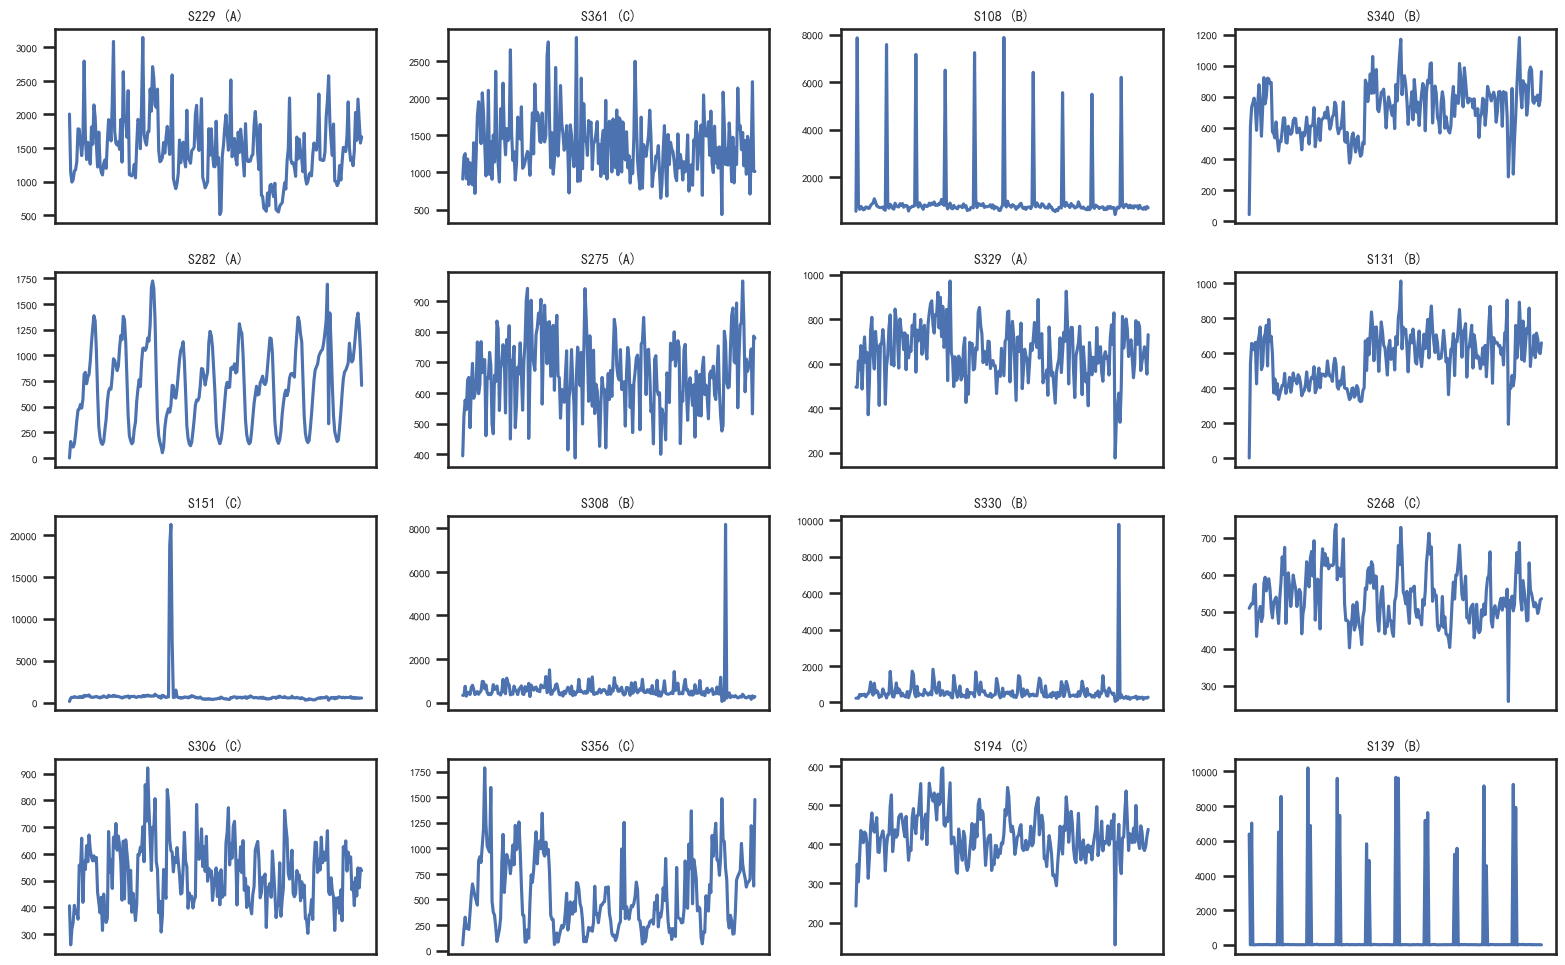

In [68]:
top_16_ids = top_50_suppliers['供应商编号'].head(16).tolist()
top_16_supply_sorted = pd.DataFrame()
for supplier_id in top_16_ids:
    match_row = supply_df[supply_df.iloc[:, 0] == supplier_id]
    if not match_row.empty:
        top_16_supply_sorted = pd.concat([top_16_supply_sorted, match_row], ignore_index=True)
weeks = [f'W{i+1}' for i in range(240)]

fig, axes = plt.subplots(4, 4, figsize=(16, 10), sharex=True)
for idx, ax in enumerate(axes.flatten()):
    if idx < len(top_16_ids):
        supplier_id = top_16_supply_sorted.iloc[idx, 0]
        category = top_16_supply_sorted.iloc[idx, 1]
        supply_values = top_16_supply_sorted.iloc[idx, 2:].values

        ax.plot(supply_values, label=f'{supplier_id} ({category})')
        ax.set_title(f"{supplier_id} ({category})", fontsize=10)
        ax.grid(False)
        ax.tick_params(axis='both', labelsize=8)
        ax.xaxis.set_ticks_position('none') 
        ax.set_xticks([])

    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig("前16家供应商供货量随时间变化.png", dpi=300)
plt.show()

# SARIMA

In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def predict_supplier_supply_next_24_weeks(supplier_id, supply_df, plot=True):
    row = supply_df[supply_df.iloc[:, 0] == supplier_id]
    if row.empty:
        raise ValueError(f"未在供货量表中找到供应商 {supplier_id}")
    supply_series = row.iloc[0, 2:].astype(float).values
    weeks = pd.date_range(start='2017-01-01', periods=len(supply_series), freq='W')
    supply_ts = pd.Series(supply_series, index=weeks)
    order = (1, 1, 1) 
    seasonal_order = (1, 1, 1, 48)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = SARIMAX(supply_ts, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)

    forecast = results.get_forecast(steps=24)
    predicted_supply = forecast.predicted_mean.values
    predicted_supply = np.where(predicted_supply < 0, 0, predicted_supply).astype(int)
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(supply_ts[-100:], label='历史供货量', marker='o', markersize=3)
        future_index = pd.date_range(start=supply_ts.index[-1], periods=25, freq='W')[1:]
        plt.plot(future_index, forecast.predicted_mean, label='预测供货量', color='r', linestyle='--', marker='x', markersize=4)
        pred_ci = forecast.conf_int()
        plt.fill_between(future_index,
                         pred_ci.iloc[:, 0], pred_ci.iloc[:, 1],
                         color='pink', alpha=0.3, label='95% 置信区间')
        plt.title(f'供应商 {supplier_id} 的供货量预测')
        plt.xlabel('时间')
        plt.ylabel('供货量 ($m^3$)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return predicted_supply

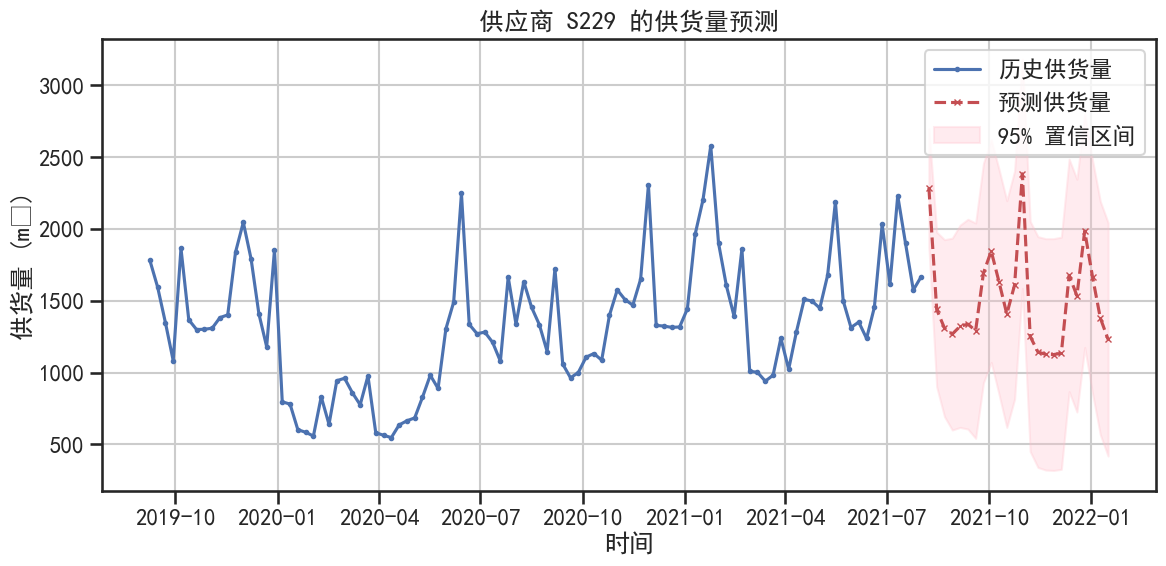

S229未来 24周供货量预测结果： [2285 1439 1309 1267 1321 1336 1291 1691 1844 1630 1406 1609 2382 1251
 1142 1126 1124 1134 1676 1534 1984 1666 1379 1230]


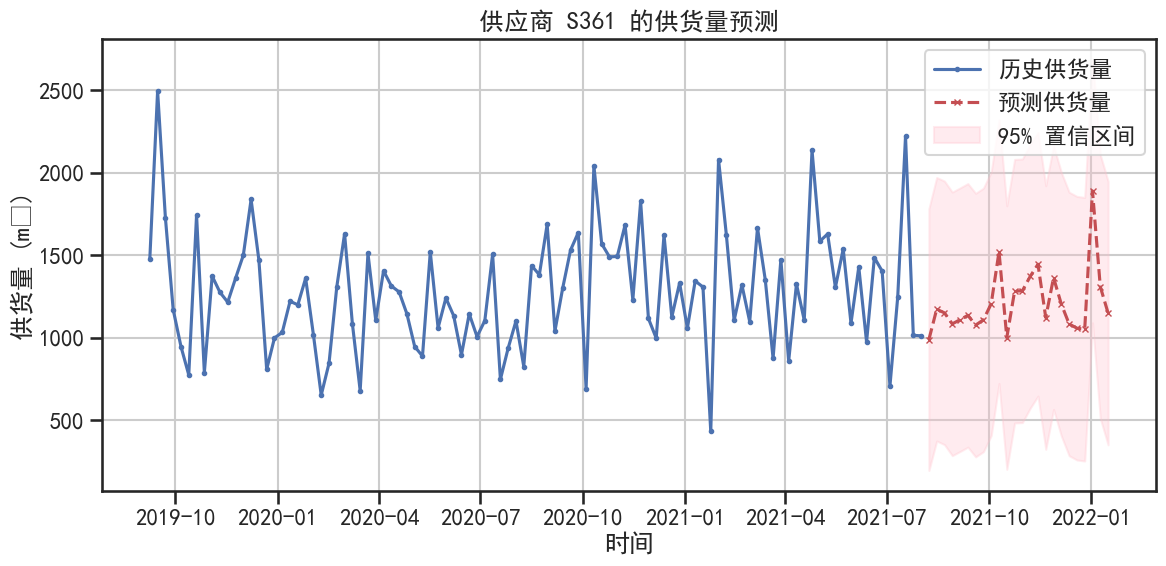

S361未来 24周供货量预测结果： [ 989 1173 1151 1084 1109 1136 1077 1108 1206 1521 1001 1282 1284 1371
 1445 1122 1364 1203 1083 1058 1051 1889 1309 1149]


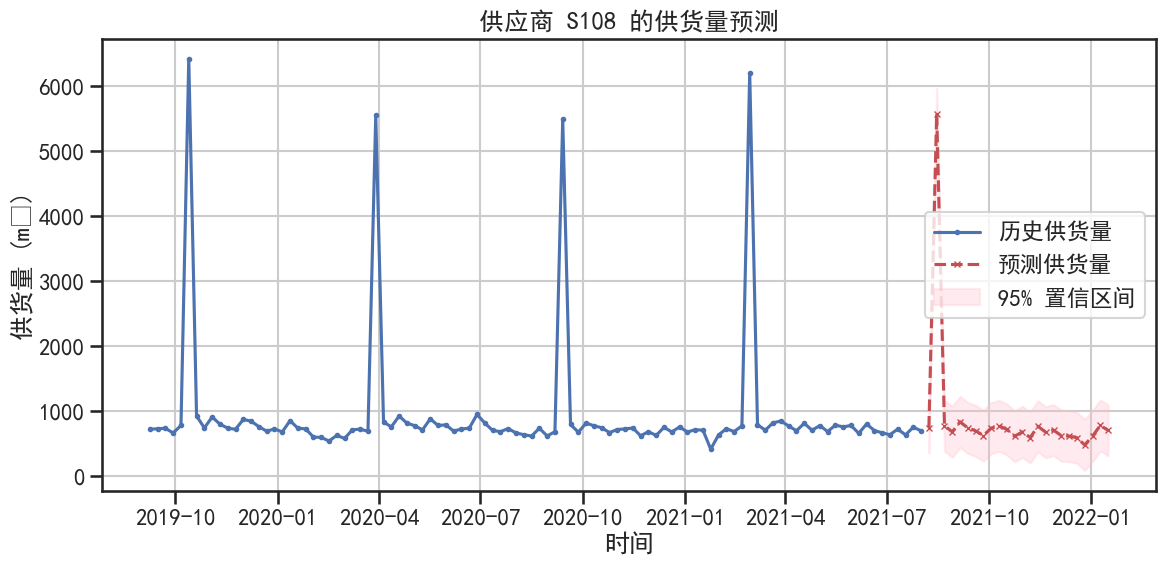

S108未来 24周供货量预测结果： [ 748 5580  776  682  837  743  698  626  740  775  719  614  682  595
  767  676  708  624  618  592  481  616  781  705]


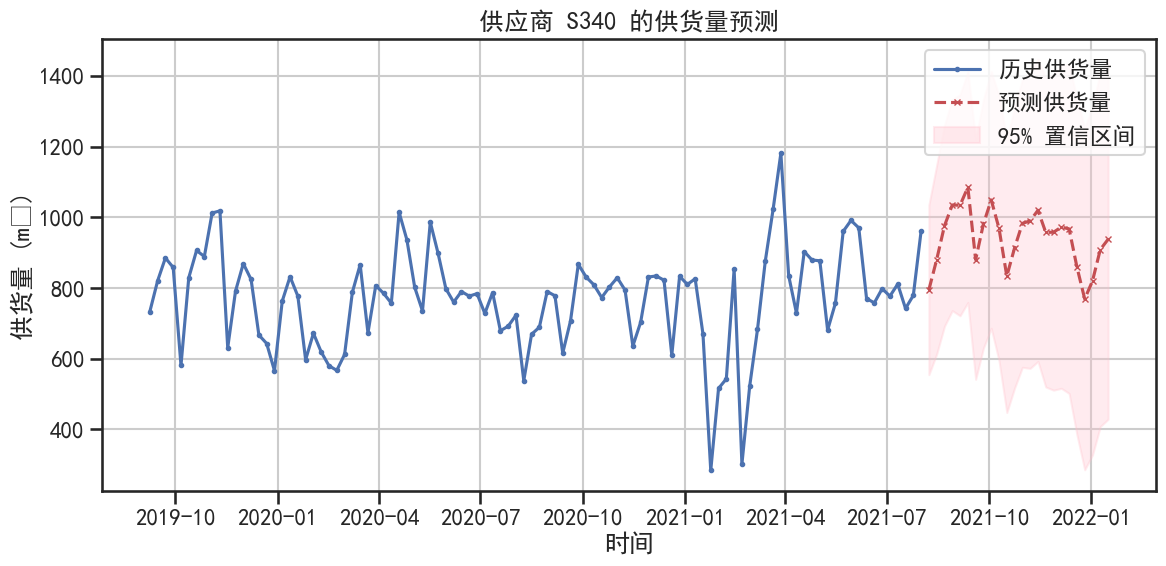

S340未来 24周供货量预测结果： [ 794  880  975 1034 1033 1084  880  981 1048  968  833  913  982  989
 1019  957  957  972  966  859  769  819  908  937]


In [81]:
top_16_ids = top_50_suppliers['供应商编号'].head(16).tolist()
for i in range(4):
    supplier_id = top_16_ids[i]
    forecast_supply = predict_supplier_supply_next_24_weeks(supplier_id, supply_df)
    print(f"{ supplier_id}未来 24周供货量预测结果：", forecast_supply)